<a href="https://colab.research.google.com/github/RajidiSahithi/SahithiR_ERA_Session7/blob/main/Model_2_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Target:**
1.   Batch Normalization is added
2. Dropout is added
3. To Make the model lighter Adaptive Global average pooling and additional layers are added
4.  To achive the better results with data augmentation techniques and filling up the training gap (Rotation is added)

# **Result:**
1.   Parameters: 7,496 (Achieved one requirement, Number of Parameters <  8000 )
2.  Best Training Accuracy: 99.25
3. Best Test Accuracy: 99.37



# **Analysis:**

1. Batch Normalization helps us to increase the training acuuracy
2. Dropout (Regularization) reduces the difference between training and test accuracy (which in turn reduces overfitting). We are making training harder.Here I used 1 % dropout.
3. Dropout and Batch Normalization cannot provide required result. Dropout reduces Training Accuracy.
4. The number of parameters are reduced by using Global Average Pooling. Here I used Adaptive average pooling.
5. But still Overfitting is there, so we added parameters at the last by adding few more layers.Which incresed the test accuracy.consistent test accuracy of 99.4% is not achieved
6. In model1 we  observed the images and found that we can apply Randon Rotation. And after rotation it is filled with black (becuase backgroung is black)
7. Still we are unable to achieve consistent test accuracy.
8. Still there is overfitting
9. So we must add lr scheduling



In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Python code snippet

Imports PyTorch’s neural network module
torch.nn and other PyTorch modules such as torch.optim, torch.nn.functional, and torchvision.datasets.


*   The torch.nn module provides classes for defining and training neural networks. It includes layers such as linear layers, convolutional layers, and recurrent layers that can be used to define the architecture of a neural network.
*   The torch.optim module provides optimization algorithms such as stochastic gradient descent (SGD) that can be used to train the neural network.


*   The torch.nn.functional module provides functions that can be used to define the loss function of the neural network.
*   The torchvision.datasets module provides datasets such as MNIST that can be used for training and testing the neural network.

In [ ]:
simple_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 412514746.54it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108447353.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 85670115.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10886016.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.Resize((28, 28)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
len(train),len(test)

(60000, 10000)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#(number of workers=no of CPU)-1
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([128, 1, 28, 28])
torch.Size([128])


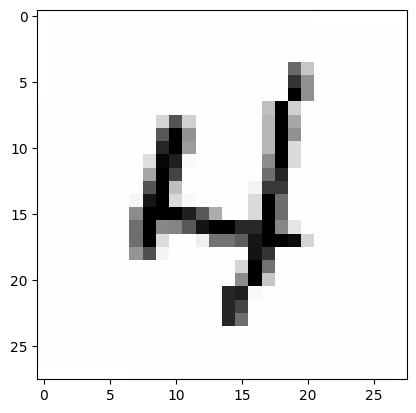

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

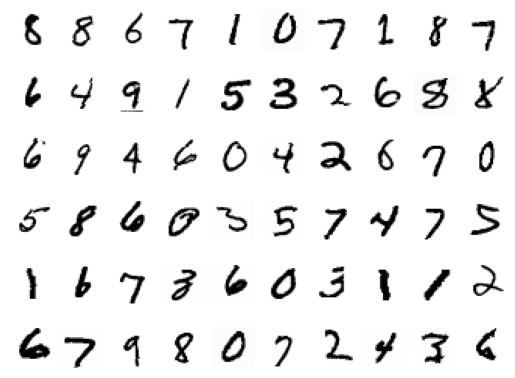

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    drop=0.01
    #INPUT BLOCK
    self.conv1= self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(drop)
        )
    #CONVOLUTIONAL BLOCK 1
    self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop)
        )
    self.maxpool1=nn.MaxPool2d(2,2)
    #TRANSITION BLOCK 1
    self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            #nn.ReLU()
        )
    # CONVOLUTION BLOCK 2
    self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(drop)
        )
    #self.maxpool2=nn.MaxPool2d(2,2)

    # GAP - Adaptive Global Average Pooling
    self.gap = nn.AdaptiveAvgPool2d(1)

    self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.maxpool1(x)
      x = self.conv3(x)
      x = self.conv4(x)
      #x = self.maxpool2(x)
      x = self.gap(x)
      x = self.conv5(x)
      x = x.view(-1, 10)
      return F.log_softmax(x,dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
           Conv2d-12           [-1, 12, 10, 10]             864

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    #traing acc<test acc is overfitting and viceversa is underfitting
    #diff b/w traing and test acc increases ---------- it causes overfitting

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06444599479436874 Batch_id=468 Accuracy=92.48: 100%|██████████| 469/469 [00:39<00:00, 11.82it/s]



Test set: Average loss: 0.0631, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.06871514022350311 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:39<00:00, 11.82it/s]



Test set: Average loss: 0.0459, Accuracy: 9860/10000 (98.60%)

EPOCH: 2


Loss=0.015449083410203457 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:38<00:00, 12.27it/s]



Test set: Average loss: 0.0379, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.07379118353128433 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]



Test set: Average loss: 0.0365, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.009682820178568363 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]



Test set: Average loss: 0.0276, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.034951504319906235 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]



Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.061446283012628555 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:40<00:00, 11.71it/s]



Test set: Average loss: 0.0263, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.057875826954841614 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0277, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.04749735817313194 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average loss: 0.0261, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.027727171778678894 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]



Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.0320342592895031 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.018141500651836395 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0259, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.012283327989280224 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.02774900011718273 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:39<00:00, 11.82it/s]



Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.002947376109659672 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)



In [ ]:
train_losses

[tensor(2.4309, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3492, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2702, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2609, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1776, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1429, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0969, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0725, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0827, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0742, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0112, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.9941, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.9718, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.9611, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.9162, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.8568, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [ ]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

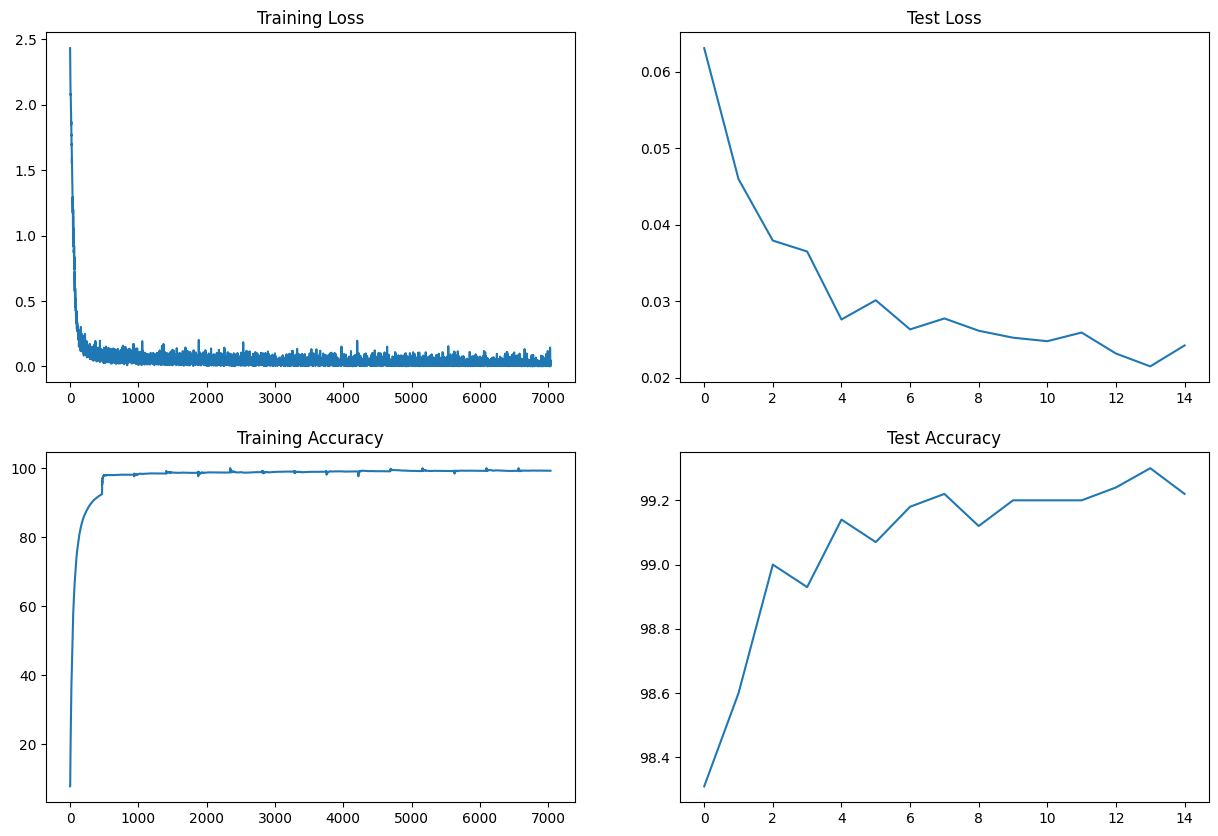

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")